## Importing Dependencies 
XSpecT relies on a number of common python packages including: 
- h5py for reading HDF5 files
- NumPy and scipy for data analysis
- Matplotlib for visualization
- Other system related packages

Depending on your system you may need to install the necessary dependencies. S3DF users should have the necessary packages by default.

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit,minimize
import multiprocessing
import os
from functools import partial
import time
import sys
import argparse
from datetime import datetime
import tempfile

## Importing XSPecT Modules
XSpecT has several main modules for function to control various aspects of the analysis, visualization, diagnostics and overall processing.

In [2]:
sys.path.insert(0, './XSpecT/')
import XSpect.XSpect_Analysis
import XSpect.XSpect_Controller
import XSpect.XSpect_Visualization
import XSpect.XSpect_PostProcessing
import XSpect.XSpect_Diagnostics

## XAS Analysis Example

### Setting up experiment parameters
Intializing the `spectroscopy_experiment` class and setting the relevant experiment information`lslc_run`, `hutch`, and `experiment_id` parameters.

In [3]:
xas_experiment = XSpect.XSpect_Analysis.spectroscopy_experiment(lcls_run=22, hutch='xcs', experiment_id='xcsl1030422')

These values will be used to obtain the directory for the data which is stored in `experiment_directory`:

In [4]:
xas_experiment.experiment_directory

'/sdf/data/lcls/ds/xcs/xcsl1030422/hdf5/smalldata'

### XASBatchAnalysis Class

Instantiating the `XASBatchAnalysis` class which allows you to set attributes relevant to the analysis such as the HDF5 group keys for the various datasets, filter thresholds, and timing/energy parameters. The class also contain an analysis pipeline method, which controls the sequence of analysis operations. 

In [5]:
xas=XSpect.XSpect_Controller.XASBatchAnalysis()

#### Setting keys and aliases
The keys, which specify the data to read from the HDF5 file, are defined as a list of strings. For pump-probe XAS measurements this typically includes: the monochromator energy and set values (epics/ccm_E, epicsUser/ccm_E_setpoint), TT correction values and amplitude (tt/ttCorr, tt/AMPL), timing stage values (epics/lxt_ttc), emission CCD ROI sum values (epix_2/ROI_0_sum) and normalization channel (ipm4/sum).

Their "friendly" names serve as an easier to remember alias for the keys and are also defined as a list of strings with the same ordering as the keys. These lists are passed to `set_key_aliases` which creates the key aliases. 

In [6]:
keys=['epics/ccm_E', 'epicsUser/ccm_E_setpoint', 'tt/ttCorr', 'epics/lxt_ttc', 'enc/lasDelay', 'ipm4/sum', 'tt/AMPL', 'epix_2/ROI_0_sum'] 
names=['ccm', 'ccm_E_setpoint', 'time_tool_correction', 'lxt_ttc', 'encoder', 'ipm', 'time_tool_ampl', 'epix']
xas.set_key_aliases(keys,names)

#### Adding filters
Filters are set using `add_filter` which takes requires the parameters 'shot_type' (e.g. xray, simultaneous), 'filter_key' (i.e. which dataset to apply the filter to), and the filter threshold.

In [7]:
xas.add_filter('xray','ipm',500.0)
xas.add_filter('simultaneous','ipm',500.0)
xas.add_filter('simultaneous','time_tool_ampl',0.01)

#### Setting runs
Multiple runs (files) can be analyzed and combined into a single data set using the `run_parser` method. Specify the runs as a list of strings or as a single string with space separated run numbers. Ranges can be specified using numbers separated by a '-'.

In [43]:
xas.run_parser(['240-243 245-254'])

#### Setting timing parameters
Delay timing range and number of points is set in picoseconds.

In [44]:
xas.mintime = -0.5
xas.maxtime = 2.0
xas.numpoints = 25

#### Normalization option
Normalization is set by default (`False`) to use an IPM sum dataset. Alternatively, the scattering liquid ring signal can be used:

In [45]:
xas.scattering=True

### Running Analysis Loop
With the necessary parameters set the analysis procedure can be initiatilized. Here you pass the experiment attributes from `xas_experiment`. For details of the step by step analysis processes set "verbose=True" (False is the default).

In [46]:
xas.primary_analysis_loop(xas_experiment, verbose=True)

Obtained shot properties
HDF5 import of keys completed. Time: 0.02 seconds
Mask: xray has been filtered on ipm by minimum threshold: 500.000
Shots removed: 2645
Mask: simultaneous has been filtered on ipm by minimum threshold: 500.000
Shots removed: 1904
Mask: simultaneous has been filtered on time_tool_ampl by minimum threshold: 0.010
Shots removed: 100
Shots combined for detector epix on filters: simultaneous and laser into epix_simultaneous_laser
Shots (12182) separated for detector epix on filters: xray and laser into epix_xray_laser
Shots combined for detector ipm on filters: simultaneous and laser into ipm_simultaneous_laser
Shots (12182) separated for detector ipm on filters: xray and laser into ipm_xray_laser
Shots combined for detector ccm on filters: simultaneous and laser into ccm_simultaneous_laser
Shots (12182) separated for detector ccm on filters: xray and laser into ccm_xray_laser
Generated timing bins from -0.500000 to 2.000000 in 25 steps.
Generated ccm bins from 7.10

#### Exploring Analyzed Runs
The data for each run is stored in `analyzed_runs` list. 

In [47]:
xas.analyzed_runs

We can check the data shape for the laser-off shots first analyzed run, which has the dimensions of 25 time bins by 54 energy bins. 

In [59]:
print("Data shape:", xas.analyzed_runs[0].epix_xray_not_laser_time_energy_binned.shape)

Data shape: (25, 54)


Since the laser the laser is off we can sum all the across all time bins for the epix and normalization channel.

In [60]:
y = np.average(xas.analyzed_runs[0].epix_xray_not_laser_time_energy_binned, axis = 0)
norm = np.average(xas.analyzed_runs[0].ipm_xray_not_laser_time_energy_binned, axis =0)

#### Plotting Laser-off Spectrum
Then the laser off spectrum can be plotted versus the monochromator energies.

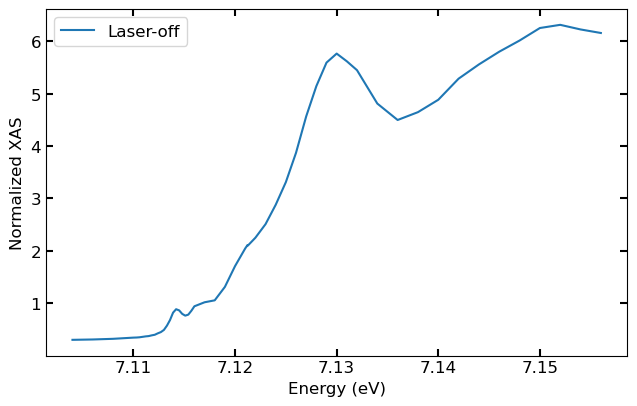

In [61]:
plt.plot(xas.analyzed_runs[0].ccm_energies, y/norm, label="Laser-off")
plt.xlabel("Energy (eV)")
plt.ylabel("Normalized XAS")
plt.legend()

#### Plotting 2D Spectra
The 2D time versus energy can be summed and plotted using the XSpecT visualation module. First, from visualization the `XASVisualization` object is instantiated. Then, use the `combine_spectra` method passing the `xas` data object and the necessary data keys.

In [62]:
v=XSpect.XSpect_Visualization.XASVisualization()
v.combine_spectra(xas_analysis=xas,
                  xas_laser_key='epix_simultaneous_laser_time_energy_binned',
                  xas_key='epix_xray_not_laser_time_energy_binned',
                  norm_laser_key='ipm_simultaneous_laser_time_energy_binned',
                  norm_key='ipm_xray_not_laser_time_energy_binned')

Finally, the 2D spectrum can be plotted, setting vmin and vmax colorbar parameters as needed.

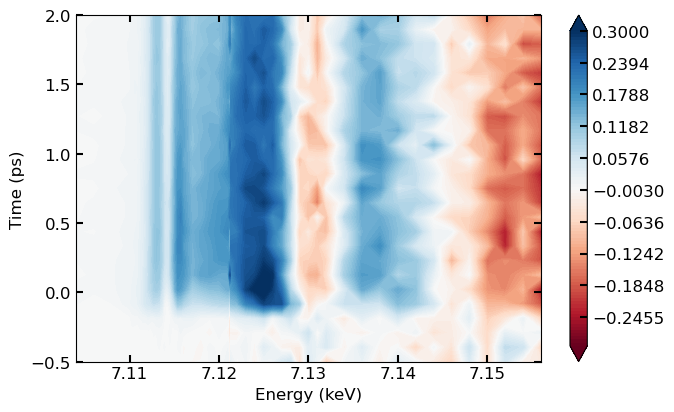

In [63]:
v.plot_2d_difference_spectrum(xas, vmin=-0.3, vmax=0.3)